# ISSS610-Applied Machine Learning
## Business Problem
The data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

# Data Set
This dataset contains 119390 observations for a City Hotel and a Resort Hotel. Each observation represents a hotel booking between the 1st of July 2015 and 31st of August 2017, including booking that effectively arrived and booking that were canceled.

https://www.sciencedirect.com/science/article/pii/S2352340918315191

Done By 
- Anna Choo Xin Yi
- Filbert
- Wesley Djingga
- Xie Jianlong
- Zhang Jieyuan


# Import Libraries

In [56]:
#Import all here
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np
import pandas as pd
import dill as pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from os.path import exists
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


## Data Retrival

In [28]:
x_under_train,x_under_test,y_under_train,y_under_test,x_train,x_test,y_train,y_test = pickle.load(open("2.out.x_y_train_test", 'rb'))

## Naive Bayes

### Load my NB Transform function

In [29]:
forest_transform = pickle.load(open("3a.out.forest_transform", 'rb'))
knn_transform = pickle.load(open("3b.out.knn_transform", 'rb'))
nb_transform = forest_transform


## Test Default Result

### Without Down Sampling - No feature Engineering

In [30]:
# Instantiate and fit the gnbClassifier
gnb = GaussianNB()

gnb.fit(nb_transform(x_train), y_train)

# Make predictions for the test set
y_pred_test_gnb = gnb.predict(nb_transform(x_test))

# # View accuracy score
print(accuracy_score(y_test, y_pred_test_gnb))

# # View confusion matrix for test_gnb data and predictions
print(confusion_matrix(y_test, y_pred_test_gnb))

# View the classification report for test_gnb data and predictions
print(classification_report(y_test, y_pred_test_gnb))

0.46430116832540025
[[ 2349 12062]
 [  318  8381]]
              precision    recall  f1-score   support

           0       0.88      0.16      0.28     14411
           1       0.41      0.96      0.58      8699

    accuracy                           0.46     23110
   macro avg       0.65      0.56      0.43     23110
weighted avg       0.70      0.46      0.39     23110



### With Down Sampling - No Feature Engineering

In [31]:
# Instantiate and fit the gnbClassifier
gnb = GaussianNB()

gnb.fit(nb_transform(x_under_train), y_under_train)
# Make predictions for the test set
y_under_pred_test_gnb = gnb.predict(nb_transform(x_under_test))

# # View accuracy score
print(accuracy_score(y_under_test, y_under_pred_test_gnb))

# # View confusion matrix for test_gnb data and predictions
print(confusion_matrix(y_under_test, y_under_pred_test_gnb))

# View the classification report for test_gnb data and predictions
print(classification_report(y_under_test, y_under_pred_test_gnb))

0.5716753022452504
[[1564 7106]
 [ 334 8366]]
              precision    recall  f1-score   support

           0       0.82      0.18      0.30      8670
           1       0.54      0.96      0.69      8700

    accuracy                           0.57     17370
   macro avg       0.68      0.57      0.49     17370
weighted avg       0.68      0.57      0.49     17370



## Feature Engineering - Using no downsampling

### Do new NB Transform here

### Train Hot Encoder

In [32]:
data = x_train

# Replace NULL values with whitespace to NaN
data.replace(r'.*NULL',np.NaN,regex=True,inplace=True)
# Convert country to region using Country_Region file
region = pd.read_csv('3e.in.country_region.csv')

region['region'] = np.where(region['region'].isna(), region['name'], region['region'])
region2 = region[['alpha-3', 'region']]
region2.columns = ['Country', 'Region1']
region3 = region[['alpha-2','region']]
region3.columns = ['Country', 'Region2']
data = data.merge(region2, how='left')
data = data.merge(region3, how='left')
data['Region'] = np.where(data['Region1'].isna(), data['Region2'], data['Region1'])
data['Region'] = np.where(data['Country']=='TMP', 'Asia', data['Region'])
data.drop(['Region1', 'Region2'], axis=1, inplace=True)

# Add rows
data['TotalStay'] = data['StaysInWeekendNights'] + data['StaysInWeekNights']
data['SameRoomAssigned'] = np.where(data['ReservedRoomType']==data['AssignedRoomType'], 1, 0)

# Drop rows
data.drop(['Country'], axis=1, inplace=True)
data.drop(['StaysInWeekNights'], axis=1, inplace=True)

# Convert binary 
data['Hotel'] = np.where(data['Hotel']=='H1', 0, 1)

binary_col = ['Children', 'Babies', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'Agent', 'Company', 'DaysInWaitingList']
for i in binary_col:
    data[i] = np.where((data[i].isna()) | (data[i]==0), 0, 1)

col = ['ArrivalDateWeekNumber', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled',
        'SameRoomAssigned', 'BookingChanges', 'Agent', 'Company', 'DaysInWaitingList', 'Hotel']

data[col] = data[col].astype('object')
categorical_non_ohe = ['Children','Babies','IsRepeatedGuest','PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges','Agent','Company','DaysInWaitingList','Hotel','SameRoomAssigned']
categorical_ohe = ['ArrivalDateWeekNumber','Adults','Meal','MarketSegment','DistributionChannel','ReservedRoomType','AssignedRoomType','DepositType','CustomerType','Region']
numerical = ['LeadTime','StaysInWeekendNights','ADR','TotalOfSpecialRequests','TotalStay']
#categorical = ['ArrivalDateWeekNumber', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'Hotel']
# numerical = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'TotalOfSpecialRequests']
categorical_ohe = ['ArrivalDateWeekNumber','Adults','Meal','MarketSegment','DistributionChannel','ReservedRoomType','AssignedRoomType','DepositType','CustomerType','Region']
#Prepare HotEncoder - To change categorical into 1,0
enc = OneHotEncoder(handle_unknown = 'ignore')

#This are column that are categorical
enc.fit(data[categorical_ohe])
#feature_name = enc.get_feature_names(x_train[categorical].columns)
# x_train_one_hot_data = enc.fit_transform(x_train[categorical]).toarray()
# x_train_one_hot_data_df= pd.DataFrame(x_train_one_hot_data)# columns= feature_name
# x_train_one_hot_data = pd.concat([x_train_one_hot_data_df, x_train[numerical].reset_index(drop=True),], axis=1)

pickle.dump(enc,open("3e.out.enc",'wb'))




In [33]:
#Do new NB Transform here

def nb_transform2(input_x):

    enc = pickle.load(open("3e.out.enc", 'rb'))
    data = input_x.copy(deep=True)

    # Replace NULL values with whitespace to NaN
    data.replace(r'.*NULL',np.NaN,regex=True,inplace=True)
    # Convert country to region using Country_Region file
    region = pd.read_csv('3e.in.country_region.csv')

    region['region'] = np.where(region['region'].isna(), region['name'], region['region'])
    region2 = region[['alpha-3', 'region']]
    region2.columns = ['Country', 'Region1']
    region3 = region[['alpha-2','region']]
    region3.columns = ['Country', 'Region2']
    data = data.merge(region2, how='left')
    data = data.merge(region3, how='left')
    data['Region'] = np.where(data['Region1'].isna(), data['Region2'], data['Region1'])
    data['Region'] = np.where(data['Country']=='TMP', 'Asia', data['Region'])
    data.drop(['Region1', 'Region2'], axis=1, inplace=True)
    
    # Add rows
    data['TotalStay'] = data['StaysInWeekendNights'] + data['StaysInWeekNights']
    data['SameRoomAssigned'] = np.where(data['ReservedRoomType']==data['AssignedRoomType'], 1, 0)
    
    # Drop rows
    data.drop(['Country'], axis=1, inplace=True)
    data.drop(['StaysInWeekNights'], axis=1, inplace=True)
    
    # Convert binary 
    data['Hotel'] = np.where(data['Hotel']=='H1', 0, 1)
    
    binary_col = ['Children', 'Babies', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'Agent', 'Company', 'DaysInWaitingList']
    for i in binary_col:
        data[i] = np.where((data[i].isna()) | (data[i]==0), 0, 1)
    
    col = ['ArrivalDateWeekNumber', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled',
           'SameRoomAssigned', 'BookingChanges', 'Agent', 'Company', 'DaysInWaitingList', 'Hotel']
    
    data[col] = data[col].astype('object')
    categorical_non_ohe = ['Children','Babies','IsRepeatedGuest','PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges','Agent','Company','DaysInWaitingList','Hotel','SameRoomAssigned']
    categorical_ohe = ['ArrivalDateWeekNumber','Adults','Meal','MarketSegment','DistributionChannel','ReservedRoomType','AssignedRoomType','DepositType','CustomerType','Region']
    numerical = ['LeadTime','StaysInWeekendNights','ADR','TotalOfSpecialRequests','TotalStay']
    input_x_one_hot_data = enc.transform(data[categorical_ohe]).toarray()
    input_x_one_hot_data_df= pd.DataFrame(input_x_one_hot_data)
    input_x_one_hot_data = pd.concat([input_x_one_hot_data_df, data[categorical_non_ohe].reset_index(drop=True),], axis=1)
    input_x_one_hot_data = pd.concat([input_x_one_hot_data, data[numerical].reset_index(drop=True),], axis=1)
    return input_x_one_hot_data
    # scaler = pickle.load(open("3b.out.scaler", 'rb'))
    # return scaler.transform(forest_transform(input_x))
def nb_scale_transform2(input_x):
    scaler = pickle.load(open("3e.out.scaler", 'rb'))
    data = nb_transform2(input_x)
    numerical = ['LeadTime','StaysInWeekendNights','ADR','TotalOfSpecialRequests','TotalStay']
    scaled = scaler.transform(data[numerical])
    scaledDF = pd.DataFrame(scaled)
    scaledDf = scaledDF.reset_index(drop=True)
    input_x_one_hot_data = pd.concat([data.drop(numerical, axis=1), scaledDF,], axis=1)
    
    return input_x_one_hot_data
pickle.dump(nb_transform2,open("3e.out.nb_transform",'wb')) 
pickle.dump(nb_scale_transform2,open("3e.out.nb_scale_transform",'wb')) 


nb_transform2 = pickle.load(open("3e.out.nb_transform", 'rb'))
scaler = MinMaxScaler()
numerical = ['LeadTime','StaysInWeekendNights','ADR','TotalOfSpecialRequests','TotalStay']
#This are column that are categorical
scaler.fit(nb_transform2(x_train)[numerical])
#feature_name = enc.get_feature_names(x_train[categorical].columns)
# x_train_one_hot_data = enc.fit_transform(x_train[categorical]).toarray()
# x_train_one_hot_data_df= pd.DataFrame(x_train_one_hot_data)# columns= feature_name
# x_train_one_hot_data = pd.concat([x_train_one_hot_data_df, x_train[numerical].reset_index(drop=True),], axis=1)

pickle.dump(scaler,open("3e.out.scaler",'wb'))

## Final Result -Without Downsampling with Feature Engineering Tuned

In [34]:
# Instantiate and fit the mnb Classifier
mnb = MultinomialNB()

mnb.fit(nb_scale_transform2(x_train), y_train)

# Make predictions for the test set
y_pred_test_gnb = mnb.predict(nb_scale_transform2(x_test))

report = """ 
Confusion_matrix:
{}
Accuracy: {}
Classification Report:
{}""".format(
metrics.confusion_matrix(y_test, y_pred_test_gnb),
metrics.accuracy_score(y_test, y_pred_test_gnb),
metrics.classification_report(y_test, y_pred_test_gnb))
print(report)

 
Confusion_matrix:
[[12944  1467]
 [ 4289  4410]]
Accuracy: 0.7509303331890956
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82     14411
           1       0.75      0.51      0.61      8699

    accuracy                           0.75     23110
   macro avg       0.75      0.70      0.71     23110
weighted avg       0.75      0.75      0.74     23110



## Performance Measure

In [35]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2021, shuffle=True)
# create model
model = MultinomialNB()
# evaluate model
scores = cross_val_score(model, nb_scale_transform2(x_train), y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.752 (0.002)


### ROC

No Skill: ROC AUC=0.500
Multinomial Naive Bayes: ROC AUC=0.777


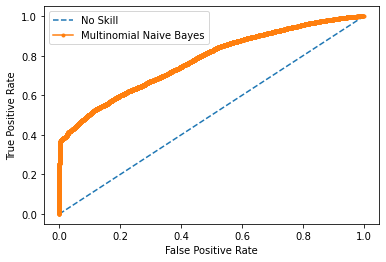

In [36]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
lr_probs = mnb.predict_proba(nb_scale_transform2(x_test))
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Multinomial Naive Bayes: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Multinomial Naive Bayes')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Export

In [37]:
pickle.dump(mnb, open('3e.out.mnb', 'wb'))